# Understanding how Active Learning affects Random Forest

This notebook explores how the active learning process affects the random forest model. The goal is to understand how the model changes as the active learning process progresses and new samples are used for training.

### 1. Import Dependencies

First, we import the necessary dependencies.

In [47]:
# Base Dependencies 
# -----------------
import numpy as np

from joblib import dump, load
from pathlib import Path
from os.path import join as pjoin
from typing import List

# Local Dependencies
# ------------------
from features import RandomForestFeaturesNegation
from models import Relation, RelationCollection
from ml_models.random_forest import RandomForestClassifierOneStage

# 3rd-Party Dependencies
# ----------------------
import dtreeviz
import seaborn as sns
from sklearn.tree import export_text, DecisionTreeClassifier


### 2. Load test data

We load the desired test dataset. In this case, we choose the Duration-Drug sub-dataset of the n2c2 corpus.

In [20]:
CORPUS = "n2c2"
REL_TYPE = "Duration-Drug"

# load test data
print("Loading test dataset...")
test_data_path: Path = Path(pjoin("..", "data", CORPUS, "test_datading", "relations.msgpack"))
test_collection: RelationCollection = RelationCollection.from_datading(CORPUS, test_data_path)
test_collection: RelationCollection = test_collection.type_subcollection(REL_TYPE)
y_test: List[float] = test_collection.labels
print(f"Test data size: {len(test_collection)}")

Loading test dataset...


100%|██████████| 41086/41086 [00:01<00:00, 28612.88it/s]

Test data size: 568


### 3. Load models

We load the two Random Forest models  obtained at two points of the Active Learning process. We first choose the two AL steps we want to analyse.

In [24]:
INIT_STEP = 5 
FINAL_STEP = 6

We load the corresponding checkpoints.

In [25]:
checkpoints_path = Path(pjoin("..", "data", "checkpoints", "al", "rf", CORPUS, REL_TYPE))

# load initial trained model, active set and  feature encoder
init_checkpoint = load(Path(pjoin(checkpoints_path, "model_" + str(INIT_STEP) + ".joblib")))
init_model: RandomForestClassifierOneStage = init_checkpoint["model"]
init_fenc: RandomForestFeaturesNegation = init_checkpoint["f_encoder"]
init_X_active: np.array = init_checkpoint["X_active"]
init_y_active: np.array = init_checkpoint["y_active"]

# load final trained model, active_set and feature encoder
final_checkpoint = load(Path(pjoin(checkpoints_path, "model_" + str(FINAL_STEP) + ".joblib")))
final_model: RandomForestClassifierOneStage = final_checkpoint["model"]
final_fenc: RandomForestFeaturesNegation = final_checkpoint["f_encoder"]
final_X_active: np.array = final_checkpoint["X_active"]
final_y_active: np.array = final_checkpoint["y_active"]

And we encode obtain the two representations of the test set. At each AL step, the different active sets give place to different values for the feature *bag of entities*, so it is necessary to obtain different test feature encodings.

In [43]:
# encode test data
init_X_test: np.array = init_fenc.transform(test_collection)
final_X_test: np.array = final_fenc.transform(test_collection)

print(f"Train data size (init): {len(init_X_active)}")
print(f"Train data size (end): {len(final_X_active)}")

Train data size (init): 112
Train data size (end): 128


### 4. Find test samples that from changes misclassified to correctly classified

We measure the gain in accuracy after adding new annotated samples in the next AL step.

In [44]:
init_score: float = init_model.clf.score(init_X_test, y_test)
final_score: float = final_model.clf.score(final_X_test, y_test)

print(f"F1-Score at step {INIT_STEP}: {init_score}")
print(f"F1-Score at step {FINAL_STEP}: {final_score}")

F1-Score at step 5: 0.7711267605633803
F1-Score at step 6: 0.8028169014084507


Since we cannot visualize all the Decision Trees in the forest, we pick one of the trees and visualize the samples that are misclassified by the initial tree and correctly classified by the final tree.

In [45]:
TREE_INDEX = 15

init_tree: DecisionTreeClassifier = init_model.clf.estimators_[TREE_INDEX]
final_tree: DecisionTreeClassifier = final_model.clf.estimators_[TREE_INDEX]

We find the samples that are misclassified by the initial model and correctly classified by the final model.

In [46]:
init_y_test_pred: float = init_tree.predict(init_X_test)
final_y_test_pred: float = final_tree.predict(final_X_test)

changed: np.array = (
    (init_y_test_pred == 0) & (final_y_test_pred == 1) & (y_test == 1)
) | ((init_y_test_pred == 1) & (final_y_test_pred == 0) & (y_test == 0))
indices: np.array = np.where(changed)

print(
    "Number of samples that are correctly classified after {} steps: {} ({:.2f}%)".format(
        FINAL_STEP - INIT_STEP, np.sum(changed), np.sum(changed) / len(changed) * 100
    )
)

Number of samples that are correctly classified after 1 steps: 147 (25.88%)


We select one of the samples whose classification changes.

In [33]:
SAMPLE_INDEX = indices[0][0]

relation: Relation = test_collection.relations[SAMPLE_INDEX]

print("Sentence: ", relation.text)
print("Type: ", relation.type)
print("e1: {}".format(relation.entity1.text))
print("e2: {}".format(relation.entity2.text))
print("Label: ", relation.label)
print("Initial prediction: ", int(init_y_test_pred[SAMPLE_INDEX]))
print("Final prediction: ", int(final_y_test_pred[SAMPLE_INDEX]))

Sentence:  10. Clonazepam 0.5 mg PO QHS:PRN anxiety/insomnia 11. MetRONIDAZOLE (FLagyl) 500 mg PO Q8H Duration: 7 Days
Type:  Duration-Drug
e1: MetRONIDAZOLE
e2: 7 Days
Label:  1
Initial prediction:  0
Final prediction:  1


### 5. Visualize a tree from the initial RF classifier

In [34]:
# color setting
COLOR_PALETTE = "Set2"
colors = sns.color_palette(COLOR_PALETTE)  # set color palette
colors_for_2_classes = [
    None,  # 0 classes
    colors[0],  # 1 class
    ['#FEFEBB', '#a1dab4'],  # 2 classes
    colors[0:4],  # 3 classes
]

We first print a textual representation of the initial decision tree.

In [56]:
print("Decision Tree at Step ", INIT_STEP)
print()
print(export_text(init_tree, spacing=3, decimals=3, feature_names=init_fenc.get_feature_names()))

Decision Tree at Step  5

|--- count_Drug <= 1.500
|   |--- punct_dist <= 1.500
|   |   |--- class: 1.0
|   |--- punct_dist >  1.500
|   |   |--- class: 0.0
|--- count_Drug >  1.500
|   |--- count_Reason <= 0.500
|   |   |--- class: 0.0
|   |--- count_Reason >  0.500
|   |   |--- class: 0.0



And a visualisation of the decision path of the chosen sample in the initial decision tree.

Decision Path at Step  5


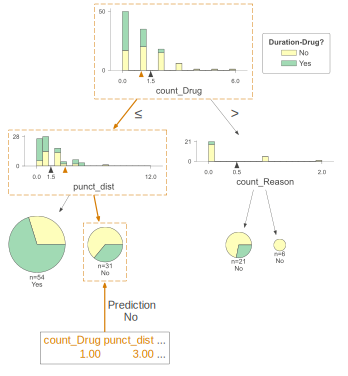

In [53]:
init_viz_model = dtreeviz.model(
    init_tree,
    X_train=init_X_active, 
    y_train=init_y_active,
    feature_names=init_fenc.get_feature_names(),
    target_name=f"{REL_TYPE}?",
    class_names=['No', 'Yes']
    )
print("Decision Path at Step ", INIT_STEP)
init_viz_model.view(x=init_X_test[SAMPLE_INDEX], colors={"classes": colors_for_2_classes})  

### 6. Visualize a tree from the final RF classifier

We repeat the process with the final decision tree.

In [57]:
print("Decision Tree at Step ", FINAL_STEP)
print()
print(export_text(final_tree, 
                  spacing=3, decimals=3,
                  feature_names=final_fenc.get_feature_names()))

Decision Tree at Step  6

|--- count_Drug <= 1.500
|   |--- punct_dist <= 0.500
|   |   |--- class: 1.0
|   |--- punct_dist >  0.500
|   |   |--- class: 1.0
|--- count_Drug >  1.500
|   |--- char_dist <= 28.000
|   |   |--- class: 1.0
|   |--- char_dist >  28.000
|   |   |--- class: 0.0



Decision Path at Step  6


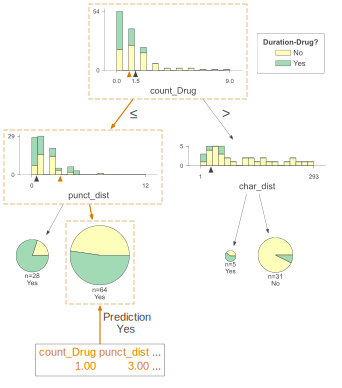

In [51]:
final_viz_model = dtreeviz.model(
    final_tree,
    X_train=final_X_active,
    y_train=final_y_active,
    feature_names=final_fenc.get_feature_names(),
    target_name=f"{REL_TYPE}?",
    class_names=["No", "Yes"],
)
print("Decision Path at Step ", FINAL_STEP)
final_viz_model.view(x=final_X_test[SAMPLE_INDEX],  colors={"classes": colors_for_2_classes})   

### Resources

- [Sklearn's `export_tree`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_text.html)
- [dtreeviz](https://github.com/parrt/dtreeviz)
